### 多语言命名实体识别(Multi-lingual Named Entity Recognition)


In [1]:
# 加载xtreme数据集
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [2]:
# 找出开头为PAN的子集
panx_subsets = [x for x in xtreme_subsets if x.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [3]:
# 加载PAN-X.de数据集
from datasets import load_dataset

load_dataset("xtreme",name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [4]:
# 加载多语言语料数据
from collections import defaultdict
from datasets import DatasetDict

langs = ['de','fr','it','en']
# 设置语言切割的百分比
fracs = [0.629,0.229,0.084,0.059]
# 返回一个DatasetDict对象，如果Key不存在
panx_ch = defaultdict(DatasetDict)

for lang,frac in zip(langs,fracs):
    # 从Hugging Face加载数据集
    ds = load_dataset("xtreme",name=f"PAN-X.{lang}")
    # 切割数据集
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows)))
        )

In [5]:
import pandas as pd

pd.DataFrame(
    {lang: [len(ds[split]) for split in ds] for lang,ds in panx_ch.items()},
    index=["train","validation","test"],
)

,de,fr,it,en
train,12580,4580,1680,1180
validation,6290,2290,840,590
test,6290,2290,840,590


> 考虑到我们的数据集中德语比例较大，那么我们将使用德语语料来作为我们的训练集。  
接下来我们检查一下德语的数据集中都有哪些东西：

In [6]:
element = panx_ch["de"]["train"][0]
for key,value in element.items():
    print(f"{key:10s}: {value}")

tokens    : ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags  : [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs     : ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [7]:
# 使用dataset.features.items()更直观的获取数据集的信息
for key,value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
# 使用嵌套feature来获得完整的实体标签
tags = panx_ch["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [9]:
# 创建一个int2str()函数来将数据集内的整数ID转换为实体标签
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}
panx_de = panx_ch["de"].map(create_tag_names)

In [10]:
# 取出德语样本
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"],de_example["ner_tags_str"]],["Tokens","Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [11]:
# 检查数据集中实体标签数量
from collections import Counter

split2freqs = defaultdict(Counter)
for split,dataset in panx_de.items():
    # 遍历行
    for row in dataset["ner_tags_str"]:
        for tag in row:
            # 检查标签是否是地域
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs,orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


### Tokenizer精进
> 与bert-case-cased使用WordPiece分词器不同的是，XLM-R使用的是被称之为SentencePiece的分词器。

In [12]:
# 加载分词器
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [13]:
# 展示BERT与XLM-A不同的分词结果
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [14]:
pd.DataFrame([bert_tokens,xlmr_tokens],["BERT","XLM-R"])

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### Tokenizer流水线
- 标准化
    - 清理空白和特殊符号
    - 标准化unicode字符
    - 大小写标准化
- 前分词
    - 主要目的是将标准的文本字符串转换为单词序列，一个最简单的示例就是把“Jack Sparrow loves New York”转换为“['Jack','Sparrow','loves','New','York']”
    - 涉及到的主要算法包括BPE(Byte Pair Encoding)和UA(Unigram Algorithm)
- 分词模型
    - 将大词分割成子词以降低词表的大小和词元列表长度
- 后处理
    - 给分割好的示例添加特殊标记

In [15]:
# SentencePiece分词器采用unicode 2581字符来表示词边界
"".join(xlmr_tokens).replace(u"\u2581"," ")

'<s> Jack Sparrow loves New York!</s>'

### 构建自定义的词元分类器

In [16]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [17]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self,config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 加载模型的主体
        self.roberta = RobertaModel(config,add_pooling_layer=False)
        # 设置词元分类头
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size,config.num_labels)
        # 加载权重
        self.init_weights()
    def forward(self,input_ids=None,attention_mask=None,token_type_ids=None,labels=None,**kwargs):
        # 使用模型主题来获取编码器主题
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs,
        )
        # 应用分类器
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 计算损失
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1,self.num_labels),labels.view(-1))
        # 返回值输出
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [18]:
# 加载自定义的XLM-R模型
# 首先我们先将要准备的index2tag和tag2index准备出来
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [19]:
# 加载XLM-R模型的配置
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes,
                                         id2label=index2tag,label2id=tag2index)

In [20]:
# 加载自定义模型
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,config=xlmr_config)
             .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# 速览一下模型的分词效果
input_ids = xlmr_tokenizer.encode(text,return_tensors="pt")
pd.DataFrame([xlmr_tokens,input_ids[0].numpy()],index=["Tokens","IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [22]:
# 使用argmax获取最终的模型输出
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs,dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs : {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs : torch.Size([1, 10, 7])


In [23]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame(
    [xlmr_tokens,preds],
    index=["Tokens","Predictions"],
)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Predictions,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


In [24]:
# 定义一个标签获取函数
def tag_text(text,tags,model,tokenizer):
    # 获取带有特殊助记符的词元
    tokens = tokenizer(text).tokens()
    # 编码序列到ID
    input_ids = xlmr_tokenizer(text,return_tensors="pt").input_ids.to(device)
    # 获取输入我说前7个最高置信度类
    output = model(input_ids)[0]
    # 获取最佳置信度预测
    predictions = torch.argmax(output,dim=2)
    # 转换为数据框
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens,preds],index=["Tokens","Tags"])

In [25]:
# 获取德语样本中的单词与标签
words,labels = de_example["tokens"],de_example["ner_tags"]

In [26]:
# 编码
tokenized_input = xlmr_tokenizer(de_example["tokens"],is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens],index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [27]:
# 使用word_ids()函数获取单词的ID
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens,word_ids],index=["Tokens","Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [28]:
# 获取label id和标签
previous_word_idx = None
label_ids = []  
for word_idx in word_ids:
    # 如果word_idx不是空的或者word_idx不等于previous_word_idx
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # 使用-100来指定Pytorch交叉熵损失函数的忽略索引
    elif word_idx != previous_word_idx: # 如果word_idx不等于previous_word_idx
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens","Word IDs","Label IDs","Labels"]

pd.DataFrame([tokens,word_ids,label_ids,labels],index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [29]:
# 定义一个分词和对其标签函数
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
    )

    labels = []
    for idx,label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [30]:
# 定义一个编码panx数据集的函数
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels,batched=True,remove_columns=["langs","ner_tags","tokens"])

In [31]:
# 接下来应用编码函数
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

### 性能评定

In [ ]:
# 使用seqeval来评估模型
!pip install seqeval

In [32]:
from seqeval.metrics import classification_report
y_true = [["O","O","O","B-MISC","I-MISC","I-MISC","O"],
          ["B-PER","I-PER","O"]]
y_pred = [["O","O","B-MISC","I-MISC","I-MISC","I-MISC","O"],
          ["B-PER","I-PER","O"]]
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [33]:
# 定义预测对其函数
import numpy as np

def align_predictions(predictions,label_ids):
    preds = np.argmax(predictions,axis=2)
    batch_size,seq_len = preds.shape
    labels_list,pred_list = [],[]

    for batch_idx in range(batch_size):
        example_labels,example_preds = [],[]
        for seq_idx in range(seq_len):
            # 如果label_ids不是-100(即交叉熵忽略的标签)
            if label_ids[batch_idx,seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx,seq_idx]])
                example_preds.append(index2tag[preds[batch_idx,seq_idx]])
        labels_list.append(example_labels)
        pred_list.append(example_preds)
    return pred_list,labels_list

In [34]:
# 微调XLM-Roberta模型
from transformers import TrainingArguments

num_epochs = 3
batch_size = 32
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [35]:
from huggingface_hub import notebook_login
notebook_login()

In [36]:
# 使用seqeval定义一个f1函数
from seqeval.metrics import f1_score
def compute_metrics(eval_pred):
    y_pred,y_true = align_predictions(eval_pred.predictions,eval_pred.label_ids)
    return {"f1": f1_score(y_true,y_pred)}

In [37]:
# 定义数据对齐
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [38]:
# 定义模型初始化函数
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(
        xlmr_model_name,
        config=xlmr_config,
    ).to(device))

In [39]:
# 加载trainer
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer,
)

In [40]:
# 训练模型
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.266100,0.164216,0.805201
2,0.128500,0.134216,0.852234
3,0.083500,0.134426,0.861296


TrainOutput(global_step=1182, training_loss=0.1592317537960869, metrics={'train_runtime': 216.3445, 'train_samples_per_second': 174.444, 'train_steps_per_second': 5.464, 'total_flos': 915382288980456.0, 'train_loss': 0.1592317537960869, 'epoch': 3.0})

In [41]:
# 尝试让模型预测一段输入文本
text_de = "Jeft Dean ist ein Informatiker bei Google in Kalifornien."
tag_text(text_de,tags,trainer.model,xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁Je,ft,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,.,</s>
Tags,O,B-PER,I-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O,O


In [42]:
# 使用交叉熵函数替代F1分数并重新训练
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 将字典列表转换为可应用于数据对齐工具的字典
    features = [dict(zip(batch,t)) for t in zip(*batch.values())]
    # 填充输入和标签，并且将张亮放到设备上
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    # 使用模型进行前向传播
    with torch.no_grad():
        # 喂数据
        output = trainer.model(
            input_ids,attention_mask)
        # 获取输出标签
        predicted_label = torch.argmax(output.logits,axis=-1).cpu().numpy()
    # 计算损失
    loss = cross_entropy(output.logits.view(-1,tags.num_classes),labels.view(-1),reduction="none")
    loss = loss.view(len(input_ids),-1).cpu().numpy()
    return {"loss":loss,"predicted_label":predicted_label}

In [43]:
# 验证集应用
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label,batched=True,batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7fb621f49a80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [44]:
# 为index2tag添加忽略
index2tag[-100] = "IGN"
# 使用tokenizer类中的内置函数来创建一个新的数据框
df["input_tokens"] = df["input_ids"].apply(lambda x:xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x:[index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x:[index2tag[i] for i in x])
df["loss"] = df.apply(lambda x:x["loss"][:len(x["input_ids"])],axis=1)   
df["predicted_label"] = df.apply(lambda x:x["predicted_label"][:len(x["input_ids"])],axis=1)

In [45]:
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0385897, 0.0, 0.026225898, 0.022164602...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [46]:
# 使用pandas.Series.explode()函数将数组“爆破”开，使其展开为多个列
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'") # 排除掉忽略项
df_tokens["loss"] = df_tokens["loss"].astype(np.float32).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.04,B-ORG,▁Ham
0,15,1,I-ORG,0.03,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.03,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.88,B-LOC,▁Luz
1,10,1,I-ORG,1.03,I-LOC,▁a


In [47]:
# 使用groupby()函数来计算每个标签的平均损失，数量
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["mean","count"])
    .droplevel(level=0,axis=1)
    .sort_values("mean",ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁Zugriff,▁wirksam,▁fach,▁Support,▁Sicher,▁Perse,▁Auckland,▁Py,▁Domina,▁Saturday
mean,9.39,8.38,8.3,8.22,7.62,7.58,7.36,7.32,7.09,6.96
count,1,1,1,1,1,1,1,1,1,1


In [48]:
# 使用groupby()函数来计算模型在哪个标签上预测的最烂
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["mean","count"])
    .droplevel(level=0,axis=1)
    .sort_values("mean",ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-PER,B-LOC,I-PER,O
mean,0.63,0.5,0.49,0.29,0.28,0.19,0.03
count,2683,1462,3820,2893,3172,4139,43648


In [49]:
import matplotlib.pyplot as plt

In [50]:
# 使用交叉矩阵检查模型的标准化误差
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

def plot_confusion_matrix(y_true,y_pred,labels):
    cm = confusion_matrix(y_true,y_pred,labels=labels,normalize="true")
    fig,ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=True)
    plt.title("Normalized Confusion Matrix")
    plt.show()

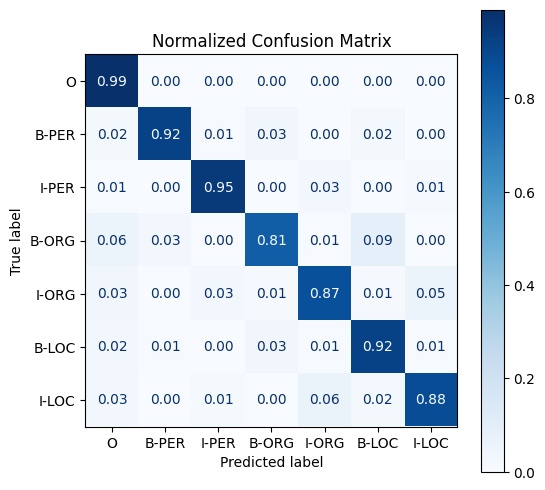

In [51]:
plot_confusion_matrix(df_tokens["labels"],df_tokens["predicted_label"],tags.names)

In [52]:
# 定义一个抽样函数
def get_sample(df):
    for _,row in df.iterrows():
        labels,preds,tokens,losses = [],[],[],[]
        for i,mask in enumerate(row["attention_mask"]):
            if i not in {0,len(row['attention_mask'])}:
                labels.append(row["labels"][i])
                preds.append(row["input_tokens"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame(
            {"tokens":tokens,"labels":labels,"preds":preds,"losses":losses}
        )
        yield df_tmp

In [53]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss",ascending=False).head(3)

In [54]:
for sample in get_sample(df_tmp):
    display(sample.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
losses,8.81,0.00,0.00,5.61,9.54,9.36,5.90,0.00,8.05,8.63,7.79,4.67,4.34,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
losses,0.00,0.00,3.01,0.00,0.00,0.00,10.71,9.96,7.98,4.14,4.18,0.00,6.03,6.74,0.00,7.37,6.72,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
losses,5.79,5.43,5.83,0.00,5.78,0.00,5.73,0.00,5.52,5.46,5.94,5.86,5.60,5.46,0.00


### 跨语言迁移(Cross-Lingual Transfer)

In [55]:
# 定义一个f1分数函数
def get_f1_score(trainer,dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [56]:
# 获取整个测试集的F1分数
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer,panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset : {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset : 0.866


In [57]:
# 在法语集上进行验证
text_fr = "Jeff Dean est information chez Google en Californie"
tag_text(text_fr,tags,trainer.model,xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,<s>,▁Jeff,▁De,an,▁est,▁information,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [58]:
# 在中文集上进行验证
text_zh = "Jeff Dean 是加州 Google 的信息员"
tag_text(text_zh,tags,trainer.model,xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,<s>,▁Jeff,▁De,an,▁,是,加州,▁Google,▁,的信息,员,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,B-ORG,I-ORG,O,O,O,I-PER


In [59]:
# 定义一个lang2lang性能验证
def evaluate_lang2lang_performance(source_lang,target_lang,trainer):
    panx_ds = encode_panx_dataset(panx_ch[target_lang])
    f1_scores[source_lang][target_lang] = get_f1_score(trainer,panx_ds["test"])
    print(f"F1 score of [{source_lang}] model on [{target_lang}] datasets : {f1_scores[source_lang][target_lang]:.3f}")

In [60]:
source_lang = "de"
target_lang = "fr"
# 执行德语到法语性能评估
evaluate_lang2lang_performance(source_lang=source_lang,target_lang=target_lang,trainer=trainer)

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1 score of [de] model on [fr] datasets : 0.698


In [61]:
# 执行德语到意大利语
source_lang = "de"
target_lang = "it"
evaluate_lang2lang_performance(source_lang,target_lang,trainer)

F1 score of [de] model on [it] datasets : 0.663


In [62]:
# 执行德语到英语
source_lang = "de"
target_lang = "en"
evaluate_lang2lang_performance(source_lang,target_lang,trainer)

F1 score of [de] model on [en] datasets : 0.591


### 验证何时零语料迁移学习能够生效？(When Does Zero-Shot Transfer make sense?)

In [63]:
# 首先定义一个子集训练函数
def training_on_subset(dataset,num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer
    )
    trainer.train()
    # 检查时候推送模型到Hugging Face
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training Complete!")
    f1_score = get_f1_score(trainer,test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples":[len(train_ds)],"f1_score":[f1_score]}
    )

In [64]:
# 编码法语数据集
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

In [65]:
training_args.push_to_hub = False
metrics_df = training_on_subset(panx_fr_encoded,250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.924600,1.391122,0.024080
2,1.346300,1.209406,0.137093
3,1.184500,1.132693,0.164344


,num_samples,f1_score
0,250,0.168428


In [66]:
# 通过调整样本数量来验证零语料微调的生效
for num_samples in [500,1000,2000,4000]:
    metrics_df = pd.concat(
        [metrics_df,training_on_subset(panx_fr_encoded,num_samples)]
    )

Epoch,Training Loss,Validation Loss,F1
1,1.659300,1.189811,0.110193
2,1.026100,0.799640,0.401150
3,0.718300,0.690092,0.533109


Epoch,Training Loss,Validation Loss,F1
1,1.239000,0.670602,0.584738
2,0.544800,0.442080,0.698017
3,0.331000,0.396726,0.740186


Epoch,Training Loss,Validation Loss,F1
1,0.886800,0.414274,0.711381
2,0.334800,0.343489,0.776463
3,0.237700,0.337337,0.797948


Epoch,Training Loss,Validation Loss,F1
1,0.617900,0.321222,0.791763
2,0.265700,0.289851,0.824040
3,0.182000,0.272304,0.834309


In [ ]:
# 绘制零语料迁移的F1分数曲线
fig,ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"],ls="--",color="orange")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero Shot from de","Fine-tuned on fr"],loc="lower right")
plt.ylim(0,1)
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### 一口气在所有语料上进行微调(Fine-Tuning on Multiple Languages at Once)

In [68]:
# 首先定义一个数据集聚合函数
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [69]:
# 创建一个德法语混编的编码数据集
panx_de_fr_encoded = concatenate_splits([panx_de_encoded,panx_fr_encoded])

In [70]:
# 开始执行多语料模型微调
training_args.push_to_hub = False
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"],
)

In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.298600,0.181280,0.828075
2,0.149500,0.157362,0.846713
3,0.098100,0.158384,0.857216


TrainOutput(global_step=1611, training_loss=0.18183037580391548, metrics={'train_runtime': 293.4524, 'train_samples_per_second': 175.429, 'train_steps_per_second': 5.49, 'total_flos': 1212862437026688.0, 'train_loss': 0.18183037580391548, 'epoch': 3.0})

In [72]:
# 检查德法模型的跨语言性能
for lang in langs:
    evaluate_lang2lang_performance(source_lang="de-fr",target_lang=lang,trainer=trainer)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1 score of [de-fr] model on [de] datasets : 0.867


F1 score of [de-fr] model on [fr] datasets : 0.860


F1 score of [de-fr] model on [it] datasets : 0.785


F1 score of [de-fr] model on [en] datasets : 0.669


In [73]:
# 将剩余的语料一起插入进行训练
corpora = [panx_de_encoded]
# 在迭代中忽略德语语料
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 在多语言语料上微调模型
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = training_on_subset(ds_encoded,ds_encoded["train"].num_rows)
    # 收集f1分数
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 添加多语言语料到corpora列表中
    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.637900,0.332381,0.780962
2,0.287700,0.282550,0.821482
3,0.191500,0.276917,0.839144


Epoch,Training Loss,Validation Loss,F1
1,0.895800,0.341710,0.741833
2,0.314000,0.280293,0.793819
3,0.208600,0.252730,0.825801


Epoch,Training Loss,Validation Loss,F1
1,1.314900,0.760671,0.500264
2,0.603200,0.450063,0.626963
3,0.406500,0.410508,0.662237


In [74]:
# 聚合数据集
corpora_encoded = concatenate_splits(corpora)

In [75]:
# 开始微调多语料模型
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"],
)

In [76]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.300800,0.185985,0.818368
2,0.154300,0.168052,0.844633
3,0.103300,0.173349,0.853724


TrainOutput(global_step=1878, training_loss=0.185942653729258, metrics={'train_runtime': 339.4518, 'train_samples_per_second': 176.932, 'train_steps_per_second': 5.532, 'total_flos': 1394212223101824.0, 'train_loss': 0.185942653729258, 'epoch': 3.0})

In [77]:
# 检查多语言性能
for idx,lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer,corpora[idx]["test"])
scores_data = {
    "de":f1_scores["de"],
    "each":{lang:f1_scores[lang][lang] for lang in langs},
    "all":f1_scores["all"],
}
f1_scores_df = pd.DataFrame.from_dict(scores_data).T.round(2)
f1_scores_df.rename_axis(index="Fine-tune on",columns="Evaluate on",inplace=True)
f1_scores_df

Evaluate on,de,fr,it,en
Fine-tune on,,,,
de,0.87,0.70,0.66,0.59
each,0.87,0.84,0.81,0.67
all,0.86,0.86,0.86,0.77
